In [1]:
import adult_data_functions as af
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Process Data

In [2]:
# Load data
categorical_feature_encoder = preprocessing.OneHotEncoder()
sex_encoder = preprocessing.LabelEncoder() 
race_encoder = preprocessing.LabelEncoder()
income_encoder = preprocessing.LabelEncoder()
train_data_dict = af.preprocess(adult_dt_path="data/adult.data", 
                                categorical_feature_encoder=categorical_feature_encoder, 
                                sex_encoder=sex_encoder, race_encoder=race_encoder, 
                                income_encoder=income_encoder, encoder_fit_boolean=True)

## Train Validation Split

In [3]:
indices_array = np.arange(train_data_dict["income-label"].shape[0])
len(indices_array)

32561

In [4]:
# split based on income
train_indices_array, val_indices_array = train_test_split(indices_array, 
                                                           stratify=train_data_dict["income-label"], 
                                                           test_size=0.1, 
                                                           random_state=0)

In [5]:
categorical_feature_train_dataset = \
    tf.data.Dataset.from_tensor_slices(train_data_dict["categorical-features"][train_indices_array, :].toarray())
categorical_feature_val_dataset = \
    tf.data.Dataset.from_tensor_slices(train_data_dict["categorical-features"][val_indices_array, :].toarray())

2022-04-21 21:43:46.973917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
continuous_feature_train_dataset = \
    tf.data.Dataset.from_tensor_slices(train_data_dict["continuous-features"].iloc[train_indices_array, :])
continuous_feature_val_dataset = \
    tf.data.Dataset.from_tensor_slices(train_data_dict["continuous-features"].iloc[val_indices_array, :])

In [7]:
feature_train_dataset = tf.data.Dataset.zip((continuous_feature_train_dataset, categorical_feature_train_dataset))
feature_val_dataset = tf.data.Dataset.zip((continuous_feature_val_dataset, categorical_feature_val_dataset))

In [8]:
# Prepare x_y_mat (sex, income)
x_y_mat = np.hstack([train_data_dict["sex"].reshape(-1, 1), train_data_dict["income-label"].reshape(-1, 1)])
x_y_mat = 2 * x_y_mat - 1
response_train_dataset = tf.data.Dataset.from_tensor_slices(x_y_mat[train_indices_array, :])
response_val_dataset = tf.data.Dataset.from_tensor_slices(x_y_mat[val_indices_array, :])

In [9]:
train_dataset = tf.data.Dataset.zip((feature_train_dataset, response_train_dataset))
val_dataset = tf.data.Dataset.zip((feature_val_dataset, response_val_dataset))

In [10]:
buffer_size = 5000
batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size)

# Training

In [11]:
model = af.ModelNetwork(number_forward_layers=1, hidden_dim=59, output_dim=2)
model.initialize();

In [12]:
f1_sex_metric = af.Metric(name="f1", response_name="sex")
f1_income_metric = af.Metric(name="f1", response_name="income-label")
accuracy_sex_metric = af.Metric(name="accuracy", response_name="sex")
accuracy_income_metric = af.Metric(name="accuracy", response_name="income-label")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=af.ising_likelihood, 
              metrics=[f1_sex_metric, f1_income_metric, accuracy_sex_metric, accuracy_income_metric],
              run_eagerly=True)

In [13]:
model.fit(train_dataset, epochs=1, validation_data=val_dataset)

458/458 [==============================] - 146s 311ms/step - loss: 140911.6562 - f1_sex: 0.0000e+00 - f1_income-label: 0.2623 - accuracy_sex: 0.2857 - accuracy_income-label: 0.1964 - val_loss: 58884.3711 - val_f1_sex: 0.0000e+00 - val_f1_income-label: 0.2857 - val_accuracy_sex: 0.4035 - val_accuracy_income-label: 0.2105


In [15]:
import matplotlib.pyplot as plt

In [16]:
model.history.history.keys()

dict_keys(['loss', 'f1_sex', 'f1_income-label', 'accuracy_sex', 'accuracy_income-label', 'val_loss', 'val_f1_sex', 'val_f1_income-label', 'val_accuracy_sex', 'val_accuracy_income-label'])

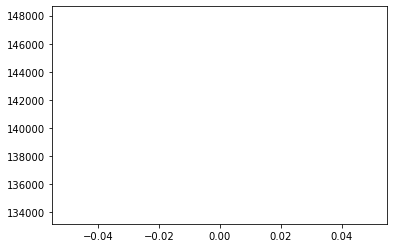

In [17]:
plt.plot(model.history.history["loss"])